In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# System
import os
import sys
sys.path.append('/home/helfrech/Tools/Toolbox/utils')

# Maths
import numpy as np

# Plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ML
from regression import PCovR, KPCovR, SparseKPCovR
from kernels import build_kernel, linear_kernel, gaussian_kernel
from kernels import center_kernel, center_kernel_fast
from kernels import center_kernel_oos, center_kernel_oos_fast

# Utilities
import h5py
import json
from tqdm.notebook import tqdm
from project_utils import load_structures_from_hdf5
from selection import FPS

In /home/helfrech/.config/matplotlib/stylelib/cosmo.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/helfrech/.config/matplotlib/stylelib/cosmoLarge.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [3]:
sys.path.append('/scratch/helfrech/Sync/GDrive/Projects/KPCovR/kernel-tutorials')
sys.path.append('/scratch/helfrech/Sync/GDrive/Projects/KPCovR/KernelPCovR/analysis/scripts')
from utilities.classes import KPCovR as KPCovR2
from helpers import l_regr, l_kpcovr

NOTE: there is variable name re-use between the different notebook "chapters". Each chapter should run independently, so it's probably a good idea to restart the kernel when moving between chapters

NOTE: all of the KPCovR fits will output a message saying no input data was provided -- this is b/c I haven't provided X data, but have provided a kernel, so it should still work as expected with the provided KPCovR utility. I have commented out the pieces in that utility that need X, since it's unnecessary here and doesn't play nicely with my keeping of structure-separated SOAP vectors as a list of arrays

NOTE: we throw out RWY since the KPCovR fitting will fail if RWY does not get assigned to the train set (ARPACK won't converge).

NOTE: per-component scaling of Y will give NaN if a property is all zero (which could be the case with one-hot encodings in this case, e.g., training on all IZA and testing on DEEM)

# TODO regress molar volume (KPCovR)

# IZA+DEEM

In [4]:
# Load train and test set indices
train_idxs = np.loadtxt('../Processed_Data/DEEM_10k/train.idxs', dtype=int)
test_idxs = np.loadtxt('../Processed_Data/DEEM_10k/test.idxs', dtype=int)

# Total number of structures
n_structures = train_idxs.size + test_idxs.size

In [5]:
# Load SOAP cutoffs
with open('../Processed_Data/soap_hyperparameters.json', 'r') as f:
    soap_hyperparameters = json.load(f)
    
cutoffs = soap_hyperparameters['interaction_cutoff']

In [6]:
# Load IZA cantons
cantons = np.loadtxt('../Raw_Data/GULP/IZA_226/cantons.txt', usecols=1, dtype=int)
n_iza = len(cantons)

In [7]:
# Build Y, place DEEM randomly in IZA cantons
#Y_deem = np.zeros((n_structures, 3))
#for cdx, canton in enumerate(np.random.randint(1, 4, n_structures)):
#    Y_deem[cdx, canton-1] = 1.0
Y_deem = np.ones((n_structures, 3)) * (1.0/3.0)

Y_iza = np.zeros((n_iza, 4))
for cdx, canton in enumerate(cantons):
    Y_iza[cdx, canton-1] = 1.0
    
# Throw out RWY and canton 4
RWY = np.nonzero(Y_iza[:, 3] == 1.0)
Y_iza = np.delete(Y_iza, RWY, axis=0)
Y_iza = np.delete(Y_iza, 3, axis=1)
cantons = np.delete(cantons, RWY)
n_iza = len(cantons)

In [8]:
print(Y_deem)

[[0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 ...
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]]


In [9]:
print(Y_iza)

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1.

In [10]:
# Subselections of train set and test set for Deem
# For IZA, just split structures 50/50
n_deem_train = 100 #2250
n_deem_test = 100 #None

deem_idxs = np.arange(0, train_idxs.size)
np.random.shuffle(deem_idxs)
deem_idxs_train = train_idxs[deem_idxs[0:n_deem_train]]

deem_idxs = np.arange(0, test_idxs.size)
np.random.shuffle(deem_idxs)
deem_idxs_test = test_idxs[deem_idxs[0:n_deem_test]]

In [11]:
n_iza_train = int(n_iza / 2)
n_iza_test = n_iza - n_iza_train
iza_idxs = np.arange(0, n_iza)
np.random.shuffle(iza_idxs)
iza_idxs_train = iza_idxs[0:n_iza_train]
iza_idxs_test = iza_idxs[n_iza_train:]

In [12]:
print(deem_idxs_train)
print(deem_idxs_test)

[3393 7129 6346 2000 1263 3448 6743 9883  161 5061 1499 9820  211 1683
 7426 3706 6157 5282 1093 2978 9302  721 2915 1964 1626 3248  698 9608
 2314 3923 7262 2153  910  442 1881 9769 6334 5610 9182 2811 3021 4058
 7470 1958 8324 5378 6403 3575 6888 7940 3691 8561 6576 6039 8025 5230
 5740 6622 2559 8151 7941 8398 2476   47 8524 9975 6617 9337 9940 4631
 5858 1412   27 5655 5622 7989 1979 9241 9502 8323 4779 7117 8043  658
 6685 6002 4541  464 9071 5866 8362 7799 4101 9511 4970 5241 5565 7202
 3221 5899]
[6555 3800 9851 4350 3253 5053 7942 6653 3879 5417 4347 7503 2483 6599
 6812 4770 1963 5101 7715 7332 3475 7654 5129 2203 7521 5973 6385 1734
  590 6577 8330 9961 9330 2500 5131 8403  662 3770 8888  401 1945 4358
 1195 7116 2398 9717 2599 1559 3737 8104 8270 6266 8378 6195 8860 3065
 2128 8153 1160  547 3834 3354 3603 8249 1596 6502 1827    4 5005 9472
 3182 5020 2397 1585 5172 5024 2827 9548 2023 2567  770 6418 6675 1885
 5069 1743 6849 8895 6143 9759 6933  145 4660 3590  109 8473 9916

In [13]:
print(iza_idxs_train)
print(iza_idxs_test)

[ 33 155 222  47 212 191  14 206 147 187 171 130  73 173  82   2 199   1
 151  79 205 182  58 189  75  68 164   3 112 114  85 118  95  94 141 101
 120  51 138  81   0 188 160 159  39  46  18  56  78  26 224  24 153 166
 116 190 121 103 201 107  16  99  61  37 163 211  20 197 170  77  63 204
  76  97  19 176 195 169  60  62 125 144 136 208  34  74 200  65  91 214
  48 119  69   9 185 113 127 161 192 110  38 134  86 215 149  71  15 126
  17 104  72   4]
[ 11  52  54 108  23  27  80 217  87 129 143 177  64  90  84  92  35 209
 162  25  66 109  30 179 150 184  49  45 142 117 194 198 145 111 158 146
 123  83 223 131 165 181  50 106  89 216 102 218  13  98 115  96 210 213
 193 122 221 175 174 156 183  44  22  36 132  28  29 157   8 100 154 152
  57 180   6 207 137 178 105  93  43  67  40  21 148   7 135  53 139  59
 186 140 168 172 202 124 133  70  42  41  32  12 196 220  31  55  10   5
 167 203 128  88 219]


In [14]:
cutoff = 6.0

# Load SOAPs
deem_file = f'../Processed_Data/DEEM_10k/Data/{cutoff}/soaps.hdf5'
deem_soaps = load_structures_from_hdf5(deem_file, datasets=None, concatenate=False)

iza_file = f'../Processed_Data/IZA_226onDEEM_10k/Data/{cutoff}/soaps.hdf5'
iza_soaps = load_structures_from_hdf5(iza_file, datasets=None, concatenate=False)
iza_soaps.pop(RWY[0][0])

array([[-0.00281038,  0.44229261,  0.12361648, ...,  0.00437123,
         0.00551277,  0.00056893],
       [-0.0028103 ,  0.44229261,  0.12361755, ...,  0.00437131,
         0.00551285,  0.00056887],
       [-0.00281031,  0.44229275,  0.1236168 , ...,  0.00437134,
         0.00551286,  0.0005689 ],
       ...,
       [-0.00281031,  0.44229311,  0.12361719, ...,  0.00437128,
         0.00551252,  0.00056898],
       [-0.00281059,  0.44229367,  0.12361391, ...,  0.00437097,
         0.00551275,  0.00056901],
       [-0.00281032,  0.44229303,  0.12361627, ...,  0.00437117,
         0.00551277,  0.00056894]])

In [15]:
# Build the collection of soap vectors
# as a list of numpy arrays, where each list element
# corresponds do a structure
deem_train = [deem_soaps[i] for i in deem_idxs_train]
deem_test = [deem_soaps[i] for i in deem_idxs_test]

iza_train = [iza_soaps[i] for i in iza_idxs_train]
iza_test = [iza_soaps[i] for i in iza_idxs_test]

train = iza_train + deem_train
test = iza_test + deem_test

In [16]:
# Concatenate the "properties"
Y_train_deem = Y_deem[deem_idxs_train, :]
Y_train_iza = Y_iza[iza_idxs_train, :]
Y_train = np.vstack((Y_train_iza, Y_train_deem))

Y_test_deem = Y_deem[deem_idxs_test, :]
Y_test_iza = Y_iza[iza_idxs_test, :]
Y_test = np.vstack((Y_test_iza, Y_test_deem))

In [17]:
for i in range(0, 3):
    print(np.count_nonzero(Y_train_deem[:, i]))

100
100
100


In [18]:
for i in range(0, 3):
    print(np.count_nonzero(Y_test_deem[:, i]))

100
100
100


In [19]:
# Build kernels, where if the SOAP vectors are provided
# as a list of arrays, the kernel is averaged over the "subkernel"
# formed by the list elements
K_train = build_kernel(train, train, kernel='gaussian', gamma=10.0)
K_test = build_kernel(test, train, kernel='gaussian', gamma=10.0)
K_test_test = build_kernel(test, test, kernel='gaussian', gamma=10.0)

100%|██████████| 213/213 [00:14<00:00, 15.19it/s]


In [20]:
# Center kernels
K_test_test_centered = center_kernel_oos(K_test_test, K_test, K_train)
K_test_centered = center_kernel(K_test, K_ref=K_train)
K_train_centered = center_kernel(K_train)

In [21]:
# Centering and scaling parameters
# (not needed here since the centering/scaling -- and post-prediction uncentering/unscaling --
# is done internally by KPCovR,
# but define them anyway just in case we need them)
Y_center = np.mean(Y_train, axis=0)
Y_scale = np.linalg.norm(Y_train-Y_center, axis=0) / np.sqrt(Y_train.shape[0] / Y_train.shape[1])
K_scale = np.trace(K_train_centered) / K_train_centered.shape[0]

In [22]:
K_test_test_centered /= K_scale
K_test_centered /= K_scale
K_train_centered /= K_scale

In [23]:
# KPCovR parameters
alphas = np.linspace(0.0, 1.0, 11)
regs = np.logspace(-12, -1, 12)
n_kpcovr = 2

# Initialize matrices of losses
lrs_train = np.zeros((alphas.size, regs.size, 3))
lks_train = np.zeros((alphas.size, regs.size, 3))
lrs_test = np.zeros((alphas.size, regs.size, 3))
lks_test = np.zeros((alphas.size, regs.size, 3))
ltrs_train = np.zeros((alphas.size, regs.size))
ltks_train = np.zeros((alphas.size, regs.size))
ltrs_test = np.zeros((alphas.size, regs.size))
ltks_test = np.zeros((alphas.size, regs.size))

# Initialize matrices of classification accuracy
class_train = np.zeros((alphas.size, regs.size))
class_test = np.zeros((alphas.size, regs.size))

# CV indices
k_folds = 5
#k_idxs = np.arange(0, Y_train[0:112].shape[0]) # Only select IZA
k_idxs = np.arange(0, Y_train.shape[0])
np.random.shuffle(k_idxs)
k_idxs = np.array_split(k_idxs, k_folds) # Use array_split since train set size not divisible by k_folds
print([k.size for k in k_idxs])
print(k_idxs)

[43, 43, 42, 42, 42]
[array([198,  36,  72, 137,  79,  50, 186, 117,  37, 104,  65,  85, 203,
        91,  82, 154,   8, 165, 196, 175,  28, 193,  62,  52,  10, 145,
        78, 167, 148, 192,  92, 187, 185,   0, 134, 183,  63, 199, 106,
        53, 101,  86,  57]), array([164,  66, 189,  59,  68, 190, 163,  84,  31,   3,  45,  96,   7,
        54,  44, 105, 125, 197, 157, 113, 173,  64,  47, 205, 151, 188,
       181, 115, 160,  48,  81,   6,  99,  43, 180,  94,  25,  32,  61,
       179,   9, 110, 108]), array([ 87,  80,   1,  19,   2, 171,  13,  21, 155,  89,  41, 161, 121,
        69, 127, 177,  98,  75, 184, 112, 136, 109, 150, 149, 209, 128,
       144, 202, 122,  15,  33, 200,  77,  22, 168, 166, 129, 182,  74,
        51,  90, 107]), array([118,   5,  18, 130,  46,  24, 208, 143, 210,  14, 103,  20, 156,
        39,  73, 170,  34,  49, 206,  30, 201, 147, 178, 191,  11,  35,
        38, 211, 124,  71,  60,  16,  67, 135, 133,   4, 140,  55,  26,
       138, 207, 139]), array([ 

In [24]:
# Determine optimal alpha and regularization via cross validation
for adx, alpha in enumerate(tqdm(alphas)):
    for rdx, r in enumerate(regs):
        for k in range(0, k_folds):
            k_idxs_train = k_idxs.copy()
            k_idxs_validate = k_idxs_train.pop(k)
            k_idxs_train = np.concatenate(k_idxs_train)
            
            # Set kernels and properties for the fold
            k_train = K_train[k_idxs_train, :][:, k_idxs_train]
            k_test = K_train[k_idxs_validate, :][:, k_idxs_train]
            k_test_test = K_train[k_idxs_validate, :][:, k_idxs_validate]
            y_train = Y_train[k_idxs_train, :]
            y_test = Y_train[k_idxs_validate, :]
            
            # Center and scale for the fold
            y_center = np.mean(y_train, axis=0)
            y_train_centered = y_train - y_center
            y_test_centered = y_test - y_center
            y_scale = np.linalg.norm(y_train_centered, axis=0) \
                / np.sqrt(y_train_centered.shape[0] / y_train_centered.shape[1])
            y_train_centered = y_train_centered / y_scale
            y_test_centered = y_test_centered / y_scale
            
            # Even though we have auto-centering and auto-scaling,
            # center and scale here for the loss functions
            k_test_test_centered = center_kernel_oos(k_test_test, k_test, k_train)
            k_test_centered = center_kernel(k_test, K_ref=k_train)
            k_train_centered = center_kernel(k_train)
            k_scale = np.trace(k_train_centered) / k_train_centered.shape[0]
            k_test_test_centered = k_test_test_centered/k_scale
            k_test_centered = k_test_centered/k_scale
            k_train_centered = k_train_centered/k_scale

            # KPCovR fit and predictions
            kpcovr = KPCovR2(alpha=alpha, n_PC=n_kpcovr, regularization=r, 
                             rcond=None, scale=True, center=True)
            kpcovr.fit(None, y_train, K=k_train_centered)
            
            t_train, yp_train, _ = kpcovr.transform(K=k_train_centered)
            t_test, yp_test, _ = kpcovr.transform(K=k_test_centered)
            
            yp_train_centered = (yp_train - y_center) / y_scale
            yp_test_centered = (yp_test - y_center) / y_scale
            
            ### Just optimize based on IZA ###
            #iza_select_train = np.nonzero(k_idxs_train < n_iza_train)[0]
            #iza_select_test = np.nonzero(k_idxs_validate < n_iza_test)[0]
            #
            #y_train_centered = y_train_centered[iza_select_train]
            #y_test_centered = y_test_centered[iza_select_test]
            #y_train = y_train[iza_select_train]
            #y_test = y_test[iza_select_test]
            #yp_train = yp_train[iza_select_train]
            #yp_test = yp_test[iza_select_test]
            #yp_train_centered = yp_train_centered[iza_select_train]
            #yp_test_centered = yp_test_centered[iza_select_test]
            #k_train_centered = k_train_centered[iza_select_train, :][:, iza_select_train]
            #k_test_centered = k_test_centered[iza_select_test, :][:, iza_select_train]
            #k_test_test_centered = k_test_test_centered[iza_select_test, :][:, iza_select_test]
            #t_train = t_train[iza_select_train, :]
            #t_test = t_test[iza_select_test, :]
            ##################################
            
            # Collect regression and projection (KPCovR) losses for each canton
            lrs_test[adx, rdx, :] += l_regr(y_test_centered, yp_test_centered)
            lks_test[adx, rdx, :] += l_kpcovr(k_train=k_train_centered,
                                        k_test=k_test_centered,
                                        k_test_test=k_test_test_centered,
                                        t_train=t_train, t_test=t_test, 
                                        pkt=kpcovr.PKT, #[iza_select_train, :], ###
                                        ptk=kpcovr.PTK) #[:, iza_select_train]) ###

            lrs_train[adx, rdx, :] += l_regr(y_train_centered, yp_train_centered)
            lks_train[adx, rdx, :] += l_kpcovr(k_train=k_train_centered,
                                         t_train=t_train, t_test=t_test, 
                                         pkt=kpcovr.PKT, #[iza_select_train, :], ###
                                         ptk=kpcovr.PTK) #[:, iza_select_train]) ###

            # Total loss as sum of cantonwise losses
            ltrs_train[adx, rdx] += np.sum(lrs_train[adx, rdx, :])
            ltks_train[adx, rdx] += np.sum(lks_train[adx, rdx, :])

            ltrs_test[adx, rdx] += np.sum(lrs_test[adx, rdx, :])
            ltks_test[adx, rdx] += np.sum(lks_test[adx, rdx, :])
            
            # Convert to integer canton
            y_true_train = np.argmax(y_train, axis=1) + 1
            y_true_test = np.argmax(y_test, axis=1) + 1

            y_pred_train = np.argmax(yp_train, axis=1) + 1
            y_pred_test = np.argmax(yp_test, axis=1) + 1
            
            class_train[adx, rdx] += np.count_nonzero(y_pred_train == y_true_train) / len(y_true_train)
            class_test[adx, rdx] += np.count_nonzero(y_pred_test == y_true_test) / len(y_true_test)
         
        # Average over the folds
        lrs_test[adx, rdx, :] /= k_folds
        lks_test[adx, rdx, :] /= k_folds

        ltrs_test[adx, rdx] /= k_folds
        ltks_test[adx, rdx] /= k_folds

        lrs_train[adx, rdx, :] /= k_folds
        lks_train[adx, rdx, :] /= k_folds

        ltrs_train[adx, rdx] /= k_folds
        ltks_train[adx, rdx] /= k_folds
        
        class_train[adx, rdx] /= k_folds
        class_test[adx, rdx] /= k_folds

In [25]:
# Extract optimal hyperparameters
#max_idx_test = np.unravel_index(np.argmax(class_test, axis=None), class_test.shape)
max_idx_test = np.unravel_index(np.argmin(ltrs_test+ltks_test, axis=None), (ltrs_test+ltks_test).shape)
opt_alpha_idx = max_idx_test[0]
opt_reg_idx = max_idx_test[1]
print(max_idx_test)
print(class_test[max_idx_test], class_train[max_idx_test])
print(alphas[max_idx_test[0]], regs[max_idx_test[1]])
print(class_test)

(8, 10)
0.38205980066445183 0.3997215454229029
0.8 0.01
[[0.41472868 0.41472868 0.41472868 0.41472868 0.41472868 0.41472868
  0.41949059 0.44772979 0.45182724 0.43366556 0.44739756 0.35337763]
 [0.42414175 0.42414175 0.42414175 0.42414175 0.42414175 0.42414175
  0.42414175 0.43831672 0.45182724 0.44307863 0.44263566 0.36301218]
 [0.42414175 0.42414175 0.42414175 0.42414175 0.42414175 0.42414175
  0.42890365 0.44307863 0.46135105 0.45249169 0.43333333 0.35813953]
 [0.42890365 0.42890365 0.42890365 0.42890365 0.42890365 0.42890365
  0.41937984 0.43831672 0.46611296 0.46666667 0.42868217 0.34872647]
 [0.4290144  0.4290144  0.4290144  0.4290144  0.4290144  0.4337763
  0.42890365 0.45249169 0.46146179 0.45238095 0.4290144  0.3393134 ]
 [0.44307863 0.44307863 0.44307863 0.44307863 0.44307863 0.44307863
  0.43831672 0.4620155  0.48050941 0.44285714 0.40996678 0.36301218]
 [0.44761905 0.44761905 0.44761905 0.44761905 0.44761905 0.44761905
  0.44285714 0.48062016 0.48992248 0.44307863 0.4100775

In [26]:
opt_alpha = alphas[opt_alpha_idx]
opt_reg = regs[opt_reg_idx]

In [27]:
# Manually set opt_alpha if we want to plot something different
#opt_alpha = 0.50

In [28]:
# KPCovR on optimal alpha
kpcovr = KPCovR2(alpha=opt_alpha, n_PC=n_kpcovr, regularization=opt_reg, rcond=None, scale=True, center=True)
kpcovr.fit(None, Y_train, K=K_train_centered)

T_train, Yp_train, _ = kpcovr.transform(K=K_train_centered)
T_test, Yp_test, _ = kpcovr.transform(K=K_test_centered)

In [29]:
# Predicted categories appear to be "probability normalized"
print(np.sum(Yp_train, axis=1))
print(np.sum(Yp_test, axis=1))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

In [30]:
# Convert one-hot encodings back into integer canton labels
Y_true_train = np.argmax(Y_train, axis=1) + 1
Y_true_test = np.argmax(Y_test, axis=1) + 1

Y_pred_train = np.argmax(Yp_train, axis=1) + 1
Y_pred_test = np.argmax(Yp_test, axis=1) + 1

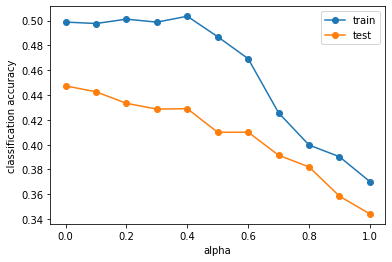

In [31]:
# Sum of projection and regression loss over all cantons for the train set
plt.plot(alphas, class_train[:, opt_reg_idx], 'o-', label='train')
plt.plot(alphas, class_test[:, opt_reg_idx], 'o-', label='test')
plt.legend()
plt.xlabel('alpha')
plt.ylabel('classification accuracy')
plt.show()

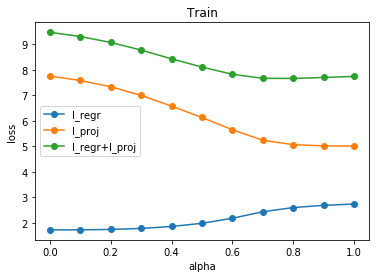

In [32]:
# Sum of projection and regression loss over all cantons for the train set
plt.plot(alphas, ltrs_train[:, opt_reg_idx], 'o-', label='l_regr')
plt.plot(alphas, ltks_train[:, opt_reg_idx], 'o-', label='l_proj')
plt.plot(alphas, ltrs_train[:, opt_reg_idx]+ltks_train[:, opt_reg_idx], 'o-', label='l_regr+l_proj')
plt.legend()
plt.title('Train')
plt.xlabel('alpha')
plt.ylabel('loss')
plt.show()

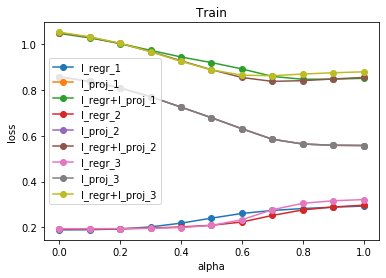

In [33]:
# Cantonwise losses for the train set
for i in range(0, 3):
    plt.plot(alphas, lrs_train[:, opt_reg_idx, i], 'o-', label=f'l_regr_{i+1}')
    plt.plot(alphas, lks_train[:, opt_reg_idx, i], 'o-', label=f'l_proj_{i+1}')
    plt.plot(alphas, lrs_train[:, opt_reg_idx, i]+lks_train[:, opt_reg_idx, i], 'o-', label=f'l_regr+l_proj_{i+1}')

plt.legend()
plt.title('Train')
plt.xlabel('alpha')
plt.ylabel('loss')
plt.show()

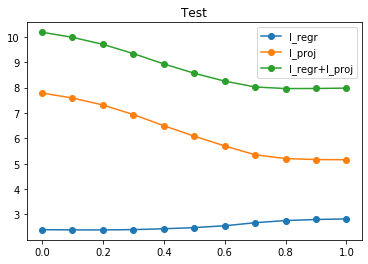

In [34]:
# Sum of projection and regression loss over all cantons for the test set
plt.plot(alphas, ltrs_test[:, opt_reg_idx], 'o-', label='l_regr')
plt.plot(alphas, ltks_test[:, opt_reg_idx], 'o-', label='l_proj')
plt.plot(alphas, ltrs_test[:, opt_reg_idx]+ltks_test[:, opt_reg_idx], 'o-', label='l_regr+l_proj')
plt.legend()
plt.title('Test')
plt.show()

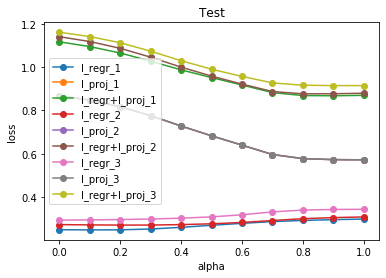

In [35]:
# Cantonwise losses for the train set
for i in range(0, 3):
    plt.plot(alphas, lrs_test[:, opt_reg_idx, i], 'o-', label=f'l_regr_{i+1}')
    plt.plot(alphas, lks_test[:, opt_reg_idx, i], 'o-', label=f'l_proj_{i+1}')
    plt.plot(alphas, lrs_test[:, opt_reg_idx, i]+lks_test[:, opt_reg_idx, i], 'o-', label=f'l_regr+l_proj_{i+1}')

plt.legend()
plt.title('Test')
plt.xlabel('alpha')
plt.ylabel('loss')
plt.show()

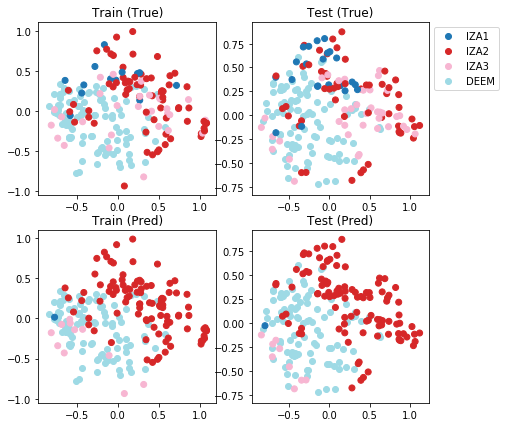

In [36]:
# Plot
fig = plt.figure(figsize=(7.0, 7.0))
axs_true_train = fig.add_subplot(2, 2, 1)
axs_true_test = fig.add_subplot(2, 2, 2)
axs_pred_train = fig.add_subplot(2, 2, 3)
axs_pred_test = fig.add_subplot(2, 2, 4)

# Scatter plots colored by canton
axs_true_train.scatter(T_train[0:112, 0], T_train[0:112, 1], c=Y_true_train[0:112], 
                       cmap='tab20', vmin=1, vmax=4, zorder=3)
axs_true_test.scatter(T_test[0:113, 0], T_test[0:113, 1], c=Y_true_test[0:113], 
                      cmap='tab20', vmin=1, vmax=4, zorder=3)
axs_pred_train.scatter(T_train[0:112, 0], T_train[0:112, 1], c=Y_pred_train[0:112], 
                       cmap='tab20', vmin=1, vmax=4, zorder=3)
axs_pred_test.scatter(T_test[0:113, 0], T_test[0:113, 1], c=Y_pred_test[0:113], 
                      cmap='tab20', vmin=1, vmax=4, zorder=2)

c_deem = np.asarray(plt.get_cmap('tab20')(1.0))[np.newaxis, :]
axs_true_train.scatter(T_train[112:, 0], T_train[112:, 1], c=c_deem)
axs_true_test.scatter(T_test[113:, 0], T_test[113:, 1], c=c_deem)
axs_pred_train.scatter(T_train[112:, 0], T_train[112:, 1], c=c_deem)
axs_pred_test.scatter(T_test[113:, 0], T_test[113:, 1], c=c_deem)

axs_true_train.set_title('Train (True)')
axs_true_test.set_title('Test (True)')

axs_pred_train.set_title('Train (Pred)')
axs_pred_test.set_title('Test (Pred)')

# Custom legend to make sure everything is colored properly
handles = [Line2D([0], [0], c=plt.get_cmap('tab20')(0.0), marker='o', linewidth=0),
           Line2D([0], [0], c=plt.get_cmap('tab20')(0.33), marker='o', linewidth=0),
           Line2D([0], [0], c=plt.get_cmap('tab20')(0.67), marker='o', linewidth=0),
           Line2D([0], [0], c=plt.get_cmap('tab20')(1.0), marker='o', linewidth=0)]

labels = ['IZA1', 'IZA2', 'IZA3', 'DEEM']
axs_true_test.legend(handles=handles, labels=labels, loc='upper left', bbox_to_anchor=(1.0, 1.0))

plt.show()

In [37]:
# Simple classification accuracy
train_accuracy = np.count_nonzero(Y_pred_train[0:n_iza_train] == Y_true_train[0:n_iza_train]) / len(Y_train[0:n_iza_train])
test_accuracy = np.count_nonzero(Y_pred_test[0:n_iza_test] == Y_true_test[0:n_iza_test]) / len(Y_test[0:n_iza_test])

print(train_accuracy)
print(test_accuracy)

0.6517857142857143
0.504424778761062


In [38]:
# Simple classification accuracy
train_accuracy = np.count_nonzero(Y_pred_train[n_iza_train:] == Y_true_train[n_iza_train:]) / len(Y_train[n_iza_train:])
test_accuracy = np.count_nonzero(Y_pred_test[n_iza_test:] == Y_true_test[n_iza_test:]) / len(Y_test[n_iza_test:])

print(train_accuracy)
print(test_accuracy)

0.14
0.08


In [39]:
# Simple classification accuracy
train_accuracy = np.count_nonzero(Y_pred_train == Y_true_train) / len(Y_train)
test_accuracy = np.count_nonzero(Y_pred_test == Y_true_test) / len(Y_test)

print(train_accuracy)
print(test_accuracy)

0.41037735849056606
0.3051643192488263


In [40]:
# Matrix of simple classification/misclassification
train_scores = np.zeros((3, 3))
test_scores = np.zeros((3, 3))
for i in range(0, 3):
    idxs_i_train = np.nonzero(Y_true_train == i+1)[0]
    idxs_i_test = np.nonzero(Y_true_test == i+1)[0]
    for j in range(0, 3):
        train_score = np.count_nonzero(Y_pred_train[idxs_i_train] == j+1) / idxs_i_train.size
        train_scores[i, j] = train_score
        
        test_score = np.count_nonzero(Y_pred_test[idxs_i_test] == j+1) / idxs_i_test.size
        test_scores[i, j] = test_score
        
print(train_scores)
print(test_scores)

[[0.12389381 0.54867257 0.32743363]
 [0.         0.95652174 0.04347826]
 [0.03333333 0.73333333 0.23333333]]
[[0.06557377 0.69672131 0.23770492]
 [0.         0.96226415 0.03773585]
 [0.02631579 0.81578947 0.15789474]]


# Deem (artificial categories)

In [41]:
# Load train and test sets
train_idxs = np.loadtxt('../Processed_Data/DEEM_10k/train.idxs', dtype=int)
test_idxs = np.loadtxt('../Processed_Data/DEEM_10k/test.idxs', dtype=int)

# Total number of structures
n_structures = train_idxs.size + test_idxs.size

In [42]:
# Subselection of train and test sets
n_deem_train = 500
n_deem_test = 500
n_total = n_deem_train + n_deem_test

deem_idxs = np.arange(0, train_idxs.size)
np.random.shuffle(deem_idxs)
deem_idxs_train = train_idxs[deem_idxs[0:n_deem_train]]

deem_idxs = np.arange(0, test_idxs.size)
np.random.shuffle(deem_idxs)
deem_idxs_test = test_idxs[deem_idxs[0:n_deem_test]]

In [43]:
# Build arbitrary canton labels for Deem, with each canton
# having equal representation in the train and test sets
deem_cantons_train = np.repeat(np.array([1, 2, 3, 4, 5]), n_deem_train/5)
deem_cantons_test = np.repeat(np.array([1, 2, 3, 4, 5]), n_deem_test/5)
np.random.shuffle(deem_cantons_train)
np.random.shuffle(deem_cantons_test)

print(deem_cantons_train)
print(deem_cantons_test)

for i in range(1, 6):
    print(np.count_nonzero(deem_cantons_train == i))
    print(np.count_nonzero(deem_cantons_test == i))

[1 1 5 2 4 2 3 3 3 2 1 3 5 5 3 2 3 1 3 4 5 4 2 5 4 4 2 4 2 2 3 5 2 1 5 2 3
 2 5 2 3 1 2 2 4 2 1 4 1 2 4 1 2 3 4 3 5 5 3 1 3 5 5 1 1 4 5 5 3 1 2 4 4 1
 2 2 4 1 1 3 2 4 3 2 5 3 1 5 3 3 3 4 3 1 4 5 5 3 1 1 5 5 3 3 1 5 2 1 1 3 3
 1 4 2 4 4 2 5 2 4 4 1 1 5 4 5 2 1 5 2 1 4 1 2 3 2 2 4 5 3 5 4 4 3 4 1 5 1
 4 3 3 5 1 4 3 5 3 5 5 5 3 3 4 4 5 5 4 4 1 3 3 3 4 5 1 2 4 2 1 1 1 5 2 4 5
 5 5 5 5 2 4 3 2 1 1 4 3 3 3 4 5 2 1 5 4 1 4 5 2 2 4 3 5 1 4 3 2 1 4 3 5 1
 5 4 1 3 3 3 4 3 5 4 1 5 5 1 3 5 2 2 3 2 2 4 5 3 5 2 4 3 3 4 2 4 4 2 5 3 1
 3 2 1 5 4 5 3 1 4 1 3 4 3 3 2 2 1 1 3 2 1 4 1 5 4 4 1 2 3 4 1 1 1 1 2 1 1
 1 5 4 5 1 5 2 1 2 3 2 4 1 3 2 4 5 3 4 1 5 3 5 4 4 4 3 4 5 5 1 3 3 4 5 4 5
 4 1 2 1 5 3 5 2 4 4 2 2 5 5 3 1 5 2 5 5 1 5 1 2 3 2 3 1 2 4 5 5 2 3 3 5 2
 3 2 4 5 1 2 3 5 2 2 1 5 2 3 2 3 3 1 4 5 1 5 3 3 1 1 2 3 3 2 2 4 2 1 5 4 2
 4 1 1 2 4 5 2 2 3 3 2 4 4 2 2 3 5 4 1 4 3 2 1 5 2 4 5 2 4 5 4 1 4 5 2 1 4
 4 3 1 3 5 5 3 2 1 2 1 4 4 1 2 2 3 2 2 3 2 5 4 4 1 5 5 4 3 4 4 2 3 1 2 2 1
 3 3 1 4 2 1 1 5 5 1 4 2 

In [44]:
# Build Y
Y_deem_train = np.zeros((n_deem_train, 5))
Y_deem_test = np.zeros((n_deem_test, 5))
for cdx, canton in enumerate(deem_cantons_train):
    Y_deem_train[cdx, canton-1] = 1.0

for cdx, canton in enumerate(deem_cantons_test):
    Y_deem_test[cdx, canton-1] = 1.0

print(Y_deem_train)
print(Y_deem_test)

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 ...
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]]


In [45]:
cutoff = 6.0

# Load SOAPs
deem_file = f'../Processed_Data/DEEM_10k/Data/{cutoff}/soaps.hdf5'
deem_soaps = load_structures_from_hdf5(deem_file, datasets=None, concatenate=False)

In [46]:
# Build the collection of soap vectors
# as a list of numpy arrays, where each list element
# corresponds do a structure
deem_train = [deem_soaps[i] for i in deem_idxs_train]
deem_test = [deem_soaps[i] for i in deem_idxs_test]

In [47]:
# Build kernels, where if the SOAP vectors are provided
# as a list of arrays, the kernel is averaged over the "subkernel"
# formed by the list elements
K_train = build_kernel(deem_train, deem_train, kernel='gaussian', gamma=10.0)
K_test = build_kernel(deem_test, deem_train, kernel='gaussian', gamma=10.0)

100%|██████████| 500/500 [00:49<00:00, 10.15it/s]


In [48]:
# Center kernels
K_test_centered = center_kernel(K_test, K_ref=K_train)
K_train_centered = center_kernel(K_train)

In [49]:
# Centering and scaling parameters
# (not needed here since the centering/scaling -- and post-prediction uncentering/unscaling --
# is done internally by KPCovR,
# but define them anyway just in case we need them)
Y_deem_center = np.mean(Y_deem_train, axis=0)
Y_scale = np.linalg.norm(Y_deem_train-Y_deem_center, axis=0) / np.sqrt(Y_deem_train.shape[0] / Y_deem_train.shape[1])
K_scale = np.trace(K_train_centered) / K_train_centered.shape[0]

In [50]:
# KPCovR parameters
alpha = 0.5
n_kpcovr = 2

In [51]:
# Build KPCovR
kpcovr = KPCovR2(alpha=alpha, n_PC=n_kpcovr, regularization=1.0E-12, rcond=None, scale=True, center=True)
kpcovr.fit(None, Y_deem_train, K=K_train_centered)

T_train, Yp_train, _ = kpcovr.transform(K=K_train_centered)
T_test, Yp_test, _ = kpcovr.transform(K=K_test_centered)

In [52]:
# Predicted categories appear to be "probability normalized"
print(np.sum(Yp_train, axis=1))
print(np.sum(Yp_test, axis=1))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

In [53]:
# Convert from one-hot encoding back to integer canton labels
Y_true_train = np.argmax(Y_deem_train, axis=1) + 1
Y_true_test = np.argmax(Y_deem_test, axis=1) + 1

Y_pred_train = np.argmax(Yp_train, axis=1) + 1
Y_pred_test = np.argmax(Yp_test, axis=1) + 1

In [54]:
# Check that the one-hot encoding/decoding works
print(np.all(Y_true_train == deem_cantons_train))
print(np.all(Y_true_test == deem_cantons_test))

True
True


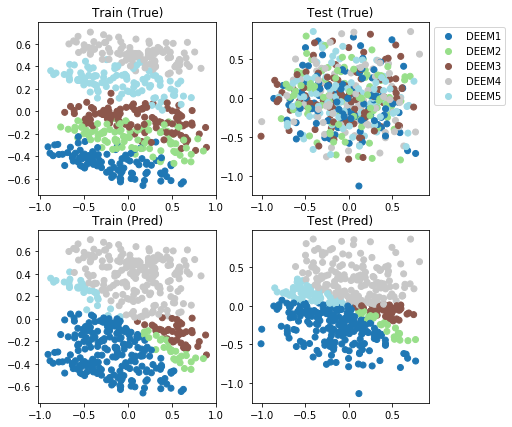

In [55]:
# Plot
fig = plt.figure(figsize=(7.0, 7.0))
axs_true_train = fig.add_subplot(2, 2, 1)
axs_true_test = fig.add_subplot(2, 2, 2)
axs_pred_train = fig.add_subplot(2, 2, 3)
axs_pred_test = fig.add_subplot(2, 2, 4)

# Scatter plots colored by canton
axs_true_train.scatter(T_train[:, 0], T_train[:, 1], c=Y_true_train, cmap='tab20', vmin=1, vmax=5)
axs_true_test.scatter(T_test[:, 0], T_test[:, 1], c=Y_true_test, cmap='tab20', vmin=1, vmax=5)
axs_pred_train.scatter(T_train[:, 0], T_train[:, 1], c=Y_pred_train, cmap='tab20', vmin=1, vmax=5)
axs_pred_test.scatter(T_test[:, 0], T_test[:, 1], c=Y_pred_test, cmap='tab20', vmin=1, vmax=5)

axs_true_train.set_title('Train (True)')
axs_true_test.set_title('Test (True)')

axs_pred_train.set_title('Train (Pred)')
axs_pred_test.set_title('Test (Pred)')

# Custom legend to make sure everything is colored correctly
handles = [Line2D([0], [0], c=plt.get_cmap('tab20')(0.0), marker='o', linewidth=0),
           Line2D([0], [0], c=plt.get_cmap('tab20')(0.25), marker='o', linewidth=0),
           Line2D([0], [0], c=plt.get_cmap('tab20')(0.50), marker='o', linewidth=0),
           Line2D([0], [0], c=plt.get_cmap('tab20')(0.75), marker='o', linewidth=0),
           Line2D([0], [0], c=plt.get_cmap('tab20')(1.0), marker='o', linewidth=0)]
labels = ['DEEM1', 'DEEM2', 'DEEM3', 'DEEM4', 'DEEM5']
axs_true_test.legend(handles=handles, labels=labels, loc='upper left', bbox_to_anchor=(1.0, 1.0))

plt.show()

In [56]:
# Simple classification accuracy
train_accuracy = np.count_nonzero(Y_pred_train == Y_true_train) / len(Y_deem_train)
test_accuracy = np.count_nonzero(Y_pred_test == Y_true_test) / len(Y_deem_test)

print(train_accuracy)
print(test_accuracy)

0.562
0.218


In [57]:
# Matrix of simple classification/misclassification
train_scores = np.zeros((5, 5))
test_scores = np.zeros((5, 5))
for i in range(0, 5):
    idxs_i_train = np.nonzero(Y_true_train == i+1)[0]
    idxs_i_test = np.nonzero(Y_true_test == i+1)[0]
    for j in range(0, 5):
        train_score = np.count_nonzero(Y_pred_train[idxs_i_train] == j+1) / idxs_i_train.size
        train_scores[i, j] = train_score
        
        test_score = np.count_nonzero(Y_pred_test[idxs_i_test] == j+1) / idxs_i_test.size
        test_scores[i, j] = test_score
        
print(train_scores)
print(test_scores)

[[0.99 0.01 0.   0.   0.  ]
 [0.71 0.2  0.09 0.   0.  ]
 [0.41 0.08 0.33 0.14 0.04]
 [0.   0.   0.   1.   0.  ]
 [0.   0.   0.01 0.7  0.29]]
[[0.48 0.06 0.05 0.32 0.09]
 [0.35 0.04 0.14 0.32 0.15]
 [0.42 0.03 0.11 0.33 0.11]
 [0.41 0.08 0.1  0.34 0.07]
 [0.41 0.03 0.12 0.32 0.12]]


# IZA only, optimized $\alpha$

In [58]:
# Load IZA cantons
cantons = np.loadtxt('../Raw_Data/GULP/IZA_226/cantons.txt', usecols=1, dtype=int)
n_iza = len(cantons)

In [59]:
# Build Y
Y_iza = np.zeros((n_iza, 4))
for cdx, canton in enumerate(cantons):
    Y_iza[cdx, canton-1] = 1.0
         
# Throw out RWY and canton 4
RWY = np.nonzero(Y_iza[:, 3] == 1.0)
Y_iza = np.delete(Y_iza, RWY, axis=0)
Y_iza = np.delete(Y_iza, 3, axis=1)
cantons = np.delete(cantons, RWY)
n_iza = len(cantons)

In [60]:
# Subselection of train set
n_iza_train = int(n_iza / 2)

iza_idxs = np.arange(0, n_iza)
np.random.shuffle(iza_idxs)
iza_idxs_train = iza_idxs[0:n_iza_train]
iza_idxs_test = iza_idxs[n_iza_train:]

In [61]:
# Check that cantonal representation in train/test sets is reasonably balanced
for i in range(1, 4):
    print(np.count_nonzero(cantons[iza_idxs_train] == i))
    print(np.count_nonzero(cantons[iza_idxs_test] == i))

13
22
62
60
37
31


In [62]:
Y_iza_train = Y_iza[iza_idxs_train]
Y_iza_test = Y_iza[iza_idxs_test]

In [63]:
cutoff = 6.0

# Load SOAPs
iza_file = f'../Processed_Data/IZA_226onDEEM_10k/Data/{cutoff}/soaps.hdf5'
iza_soaps = load_structures_from_hdf5(iza_file, datasets=None, concatenate=False)
iza_soaps.pop(RWY[0][0])

array([[-0.00281038,  0.44229261,  0.12361648, ...,  0.00437123,
         0.00551277,  0.00056893],
       [-0.0028103 ,  0.44229261,  0.12361755, ...,  0.00437131,
         0.00551285,  0.00056887],
       [-0.00281031,  0.44229275,  0.1236168 , ...,  0.00437134,
         0.00551286,  0.0005689 ],
       ...,
       [-0.00281031,  0.44229311,  0.12361719, ...,  0.00437128,
         0.00551252,  0.00056898],
       [-0.00281059,  0.44229367,  0.12361391, ...,  0.00437097,
         0.00551275,  0.00056901],
       [-0.00281032,  0.44229303,  0.12361627, ...,  0.00437117,
         0.00551277,  0.00056894]])

In [64]:
# Build the collection of soap vectors
# as a list of numpy arrays, where each list element
# corresponds do a structure
iza_train = [iza_soaps[i] for i in iza_idxs_train]
iza_test = [iza_soaps[i] for i in iza_idxs_test]

In [65]:
# Build kernels, where if the SOAP vectors are provided
# as a list of arrays, the kernel is averaged over the "subkernel"
# formed by the list elements
K_train = build_kernel(iza_train, iza_train, kernel='gaussian', gamma=10.0)
K_test = build_kernel(iza_test, iza_train, kernel='gaussian', gamma=10.0)
K_test_test = build_kernel(iza_test, iza_test, kernel='gaussian', gamma=10.0)

100%|██████████| 113/113 [00:05<00:00, 22.16it/s]


In [66]:
# Center kernels
K_test_test_centered = center_kernel_oos(K_test_test, K_test, K_train)
K_test_centered = center_kernel(K_test, K_ref=K_train)
K_train_centered = center_kernel(K_train)

In [67]:
# Check the centering
print(np.mean(K_test_test_centered), 
      np.mean(K_test_test_centered, axis=0), 
      np.mean(K_test_test_centered, axis=1))
print(np.mean(K_test_centered), 
      np.mean(K_test_centered, axis=0), 
      np.mean(K_test_centered, axis=1))
print(np.mean(K_train_centered), 
      np.mean(K_train_centered, axis=0), 
      np.mean(K_train_centered, axis=1))

0.003495313652989679 [ 2.85389441e-03  1.14268440e-02  6.68992997e-03  2.03884196e-03
  4.75000186e-03  6.59539485e-04  1.32941659e-03  1.48839608e-02
 -1.07060833e-02 -1.21941004e-03  1.22098141e-02  2.29763289e-03
  1.77689908e-03  8.03438733e-03 -2.21268401e-03  2.06376205e-03
  4.34988581e-04  5.60213443e-03 -1.32934288e-03 -4.18989407e-03
  1.48667626e-03  1.00587091e-03  1.06410024e-02  5.49520150e-03
 -2.46533492e-03  1.03248340e-02  1.05967647e-02 -2.64432523e-03
  2.85783459e-03  2.86758860e-03 -7.25668767e-03  2.93284236e-04
  9.50435599e-03  2.01851574e-03  1.97145330e-03  1.93737268e-02
  1.30614964e-02  1.19639184e-02 -9.87479282e-03  6.63035501e-04
 -2.08348428e-03  2.78597110e-03  4.49184057e-03  1.23878839e-02
  3.54933655e-04  5.10627259e-03  3.72911705e-03 -2.12236230e-03
  1.16319786e-02 -7.93461426e-03 -5.89240542e-03 -2.02230095e-03
 -5.17182477e-03  6.53456379e-03 -2.02822595e-02  2.67337779e-04
  2.84755161e-03  1.02296230e-02 -4.12630585e-03 -1.97649127e-03
  7.

In [68]:
# Compute centering and scaling
# (shouldn't need to center/scale Y b/c this is done internally by KPCovR,
# and the resulting predictions Yp_train/Yp_test should be uncentered/unscaled
# and thus compatible with the original Y)
# However, we do need to scale the kernels as this is not done internally by the loss functions
Y_iza_center = np.mean(Y_iza_train, axis=0)
Y_scale = np.linalg.norm(Y_iza_train-Y_iza_center, axis=0) / np.sqrt(Y_iza_train.shape[0] / Y_iza_train.shape[1])
K_scale = np.trace(K_train_centered) / K_train_centered.shape[0]

In [69]:
# Scale kernels (for the loss functions)
K_test_test_centered /= K_scale
K_test_centered /= K_scale
K_train_centered /= K_scale

In [70]:
# KPCovR parameters
alphas = np.linspace(0.0, 1.0, 11)
regs = np.logspace(-12, -1, 12)
n_kpcovr = 2

# Initialize matrices of losses
lrs_train = np.zeros((alphas.size, regs.size, 3))
lks_train = np.zeros((alphas.size, regs.size, 3))
lrs_test = np.zeros((alphas.size, regs.size, 3))
lks_test = np.zeros((alphas.size, regs.size, 3))
ltrs_train = np.zeros((alphas.size, regs.size))
ltks_train = np.zeros((alphas.size, regs.size))
ltrs_test = np.zeros((alphas.size, regs.size))
ltks_test = np.zeros((alphas.size, regs.size))

# Initialize matrices of classification accuracy
class_train = np.zeros((alphas.size, regs.size))
class_test = np.zeros((alphas.size, regs.size))

# CV indices
k_folds = 5
k_idxs = np.arange(0, iza_idxs_train.size)
np.random.shuffle(k_idxs)
k_idxs = np.array_split(k_idxs, k_folds) # Use array_split since train set size not divisible by k_folds
print([k.size for k in k_idxs])
print(k_idxs)

[23, 23, 22, 22, 22]
[array([ 66,  75,  39,  24,  20,  11,  45,   4,  38,  41,  83,  13,  16,
        67,  44, 110,  21,  77,  81,  48,   1,  90,   7]), array([103,  18,   8,  63,  78,  91,  32,  93,   9,  64,  85,  73,  65,
        54,  59,  68,  25,  57,  40, 102, 105,  26,  35]), array([ 23,  87,   6,  98,  60, 111,  88,  31,  27,  58, 107,  71,  14,
        30,  34,   5,  10,  53,   2,  92,  28,  86]), array([ 22,  94,  29,  96, 108,  99,  43,  72,  51,  70,  42, 104,  49,
        47,  80,  89,  55, 100,   0,  74,  95,  52]), array([ 69,  50,  79,  37,  61,  46,  17,  33,   3, 109,  36,  97,  82,
       101,  15,  76,  19,  56,  12,  84,  62, 106])]


In [71]:
# Determine optimal alpha and regularization via cross validation
for adx, alpha in enumerate(tqdm(alphas)):
    for rdx, r in enumerate(regs):
        for k in range(0, k_folds):
            k_idxs_train = k_idxs.copy()
            k_idxs_validate = k_idxs_train.pop(k)
            k_idxs_train = np.concatenate(k_idxs_train)
            
            # Set kernels and properties for the fold
            k_train = K_train[k_idxs_train, :][:, k_idxs_train]
            k_test = K_train[k_idxs_validate, :][:, k_idxs_train]
            k_test_test = K_train[k_idxs_validate, :][:, k_idxs_validate]
            y_train = Y_train[k_idxs_train, :]
            y_test = Y_train[k_idxs_validate, :]
            
            # Center and scale for the fold
            y_center = np.mean(y_train, axis=0)
            y_train_centered = y_train - y_center
            y_test_centered = y_test - y_center
            y_scale = np.linalg.norm(y_train_centered, axis=0) \
                / np.sqrt(y_train_centered.shape[0] / y_train_centered.shape[1])
            y_train_centered = y_train_centered / y_scale
            y_test_centered = y_test_centered / y_scale
            
            # Even though we have auto-centering and auto-scaling,
            # center and scale here for the loss functions
            k_test_test_centered = center_kernel_oos(k_test_test, k_test, k_train)
            k_test_centered = center_kernel(k_test, K_ref=k_train)
            k_train_centered = center_kernel(k_train)
            k_scale = np.trace(k_train_centered) / k_train_centered.shape[0]
            k_test_test_centered = k_test_test_centered/k_scale
            k_test_centered = k_test_centered/k_scale
            k_train_centered = k_train_centered/k_scale

            # KPCovR fit and predictions
            kpcovr = KPCovR2(alpha=alpha, n_PC=n_kpcovr, regularization=r, 
                             rcond=None, scale=True, center=True)
            kpcovr.fit(None, y_train, K=k_train_centered)
            
            t_train, yp_train, _ = kpcovr.transform(K=k_train_centered)
            t_test, yp_test, _ = kpcovr.transform(K=k_test_centered)
            
            yp_train_centered = (yp_train - y_center) / y_scale
            yp_test_centered = (yp_test - y_center) / y_scale

            # Collect regression and projection (KPCovR) losses for each canton
            lrs_test[adx, rdx, :] += l_regr(y_test_centered, yp_test_centered)
            lks_test[adx, rdx, :] += l_kpcovr(k_train=k_train_centered,
                                        k_test=k_test_centered,
                                        k_test_test=k_test_test_centered,
                                        t_train=t_train, t_test=t_test, 
                                        pkt=kpcovr.PKT, ptk=kpcovr.PTK)

            lrs_train[adx, rdx, :] += l_regr(y_train_centered, yp_train_centered)
            lks_train[adx, rdx, :] += l_kpcovr(k_train=k_train_centered,
                                         t_train=t_train, t_test=t_test, 
                                         pkt=kpcovr.PKT, ptk=kpcovr.PTK)

            # Total loss as sum of cantonwise losses
            ltrs_train[adx, rdx] += np.sum(lrs_train[adx, rdx, :])
            ltks_train[adx, rdx] += np.sum(lks_train[adx, rdx, :])

            ltrs_test[adx, rdx] += np.sum(lrs_test[adx, rdx, :])
            ltks_test[adx, rdx] += np.sum(lks_test[adx, rdx, :])
            
            # Convert to integer canton
            y_true_train = np.argmax(y_train, axis=1) + 1
            y_true_test = np.argmax(y_test, axis=1) + 1

            y_pred_train = np.argmax(yp_train, axis=1) + 1
            y_pred_test = np.argmax(yp_test, axis=1) + 1
            
            class_train[adx, rdx] += np.count_nonzero(y_pred_train == y_true_train) / len(y_true_train)
            class_test[adx, rdx] += np.count_nonzero(y_pred_test == y_true_test) / len(y_true_test)
         
        # Average over the folds
        lrs_test[adx, rdx, :] /= k_folds
        lks_test[adx, rdx, :] /= k_folds

        ltrs_test[adx, rdx] /= k_folds
        ltks_test[adx, rdx] /= k_folds

        lrs_train[adx, rdx, :] /= k_folds
        lks_train[adx, rdx, :] /= k_folds

        ltrs_train[adx, rdx] /= k_folds
        ltks_train[adx, rdx] /= k_folds
        
        class_train[adx, rdx] /= k_folds
        class_test[adx, rdx] /= k_folds

In [72]:
# Extract optimal hyperparameters
#max_idx_test = np.unravel_index(np.argmax(class_test, axis=None), class_test.shape)
max_idx_test = np.unravel_index(np.argmin(ltrs_test+ltks_test, axis=None), (ltrs_test+ltks_test).shape)
opt_alpha_idx = max_idx_test[0]
opt_reg_idx = max_idx_test[1]
print(max_idx_test)
print(class_test[max_idx_test], class_train[max_idx_test])
print(alphas[max_idx_test[0]], regs[max_idx_test[1]])
print(class_test)

(10, 0)
0.5988142292490118 0.6228464419475656
1.0 1e-12
[[0.41936759 0.41936759 0.41936759 0.41936759 0.41936759 0.41936759
  0.41936759 0.41976285 0.37509881 0.38458498 0.54545455 0.59011858]
 [0.41936759 0.41936759 0.41936759 0.41936759 0.41936759 0.41936759
  0.41936759 0.41976285 0.37509881 0.38458498 0.54545455 0.59011858]
 [0.41936759 0.41936759 0.41936759 0.41936759 0.41936759 0.41936759
  0.41936759 0.41067194 0.37509881 0.38458498 0.54545455 0.59881423]
 [0.41027668 0.41027668 0.41027668 0.41027668 0.41027668 0.41027668
  0.41027668 0.41067194 0.37509881 0.38458498 0.55454545 0.59881423]
 [0.41027668 0.41027668 0.41027668 0.41027668 0.41027668 0.41027668
  0.41027668 0.41067194 0.37509881 0.38458498 0.55454545 0.59011858]
 [0.42806324 0.42806324 0.42806324 0.42806324 0.42806324 0.42806324
  0.42806324 0.41067194 0.38379447 0.40237154 0.56324111 0.59011858]
 [0.48142292 0.48142292 0.48142292 0.48142292 0.48142292 0.48142292
  0.48142292 0.44624506 0.40158103 0.43754941 0.589723

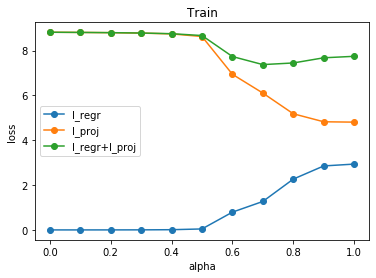

In [73]:
# Sum of projection and regression loss over all cantons for the train set
plt.plot(alphas, ltrs_train[:, opt_reg_idx], 'o-', label='l_regr')
plt.plot(alphas, ltks_train[:, opt_reg_idx], 'o-', label='l_proj')
plt.plot(alphas, ltrs_train[:, opt_reg_idx]+ltks_train[:, opt_reg_idx], 'o-', label='l_regr+l_proj')
plt.legend()
plt.title('Train')
plt.xlabel('alpha')
plt.ylabel('loss')
plt.show()

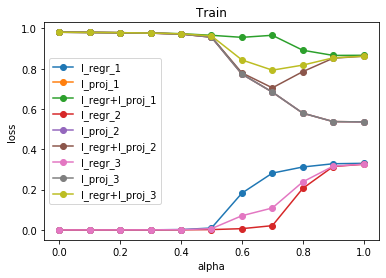

In [74]:
# Cantonwise losses for the train set
for i in range(0, 3):
    plt.plot(alphas, lrs_train[:, opt_reg_idx, i], 'o-', label=f'l_regr_{i+1}')
    plt.plot(alphas, lks_train[:, opt_reg_idx, i], 'o-', label=f'l_proj_{i+1}')
    plt.plot(alphas, lrs_train[:, opt_reg_idx, i]+lks_train[:, opt_reg_idx, i], 'o-', label=f'l_regr+l_proj_{i+1}')

plt.legend()
plt.title('Train')
plt.xlabel('alpha')
plt.ylabel('loss')
plt.show()

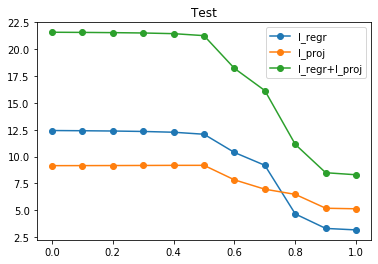

In [75]:
# Sum of projection and regression loss over all cantons for the test set
plt.plot(alphas, ltrs_test[:, opt_reg_idx], 'o-', label='l_regr')
plt.plot(alphas, ltks_test[:, opt_reg_idx], 'o-', label='l_proj')
plt.plot(alphas, ltrs_test[:, opt_reg_idx]+ltks_test[:, opt_reg_idx], 'o-', label='l_regr+l_proj')
plt.legend()
plt.title('Test')
plt.show()

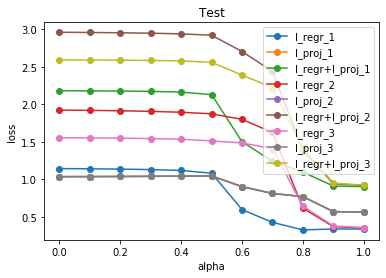

In [76]:
# Cantonwise losses for the train set
for i in range(0, 3):
    plt.plot(alphas, lrs_test[:, opt_reg_idx, i], 'o-', label=f'l_regr_{i+1}')
    plt.plot(alphas, lks_test[:, opt_reg_idx, i], 'o-', label=f'l_proj_{i+1}')
    plt.plot(alphas, lrs_test[:, opt_reg_idx, i]+lks_test[:, opt_reg_idx, i], 'o-', label=f'l_regr+l_proj_{i+1}')

plt.legend()
plt.title('Test')
plt.xlabel('alpha')
plt.ylabel('loss')
plt.show()

In [77]:
opt_alpha = alphas[opt_alpha_idx]
opt_reg = regs[opt_reg_idx]

In [78]:
# Manually set opt_alpha if we want to plot something different
#opt_alpha = 0.50

In [79]:
# KPCovR on optimal alpha
kpcovr = KPCovR2(alpha=opt_alpha, n_PC=n_kpcovr, regularization=opt_reg, rcond=None, scale=True, center=True)
kpcovr.fit(None, Y_iza_train, K=K_train_centered)

T_train, Yp_train, _ = kpcovr.transform(K=K_train_centered)
T_test, Yp_test, _ = kpcovr.transform(K=K_test_centered)

In [80]:
# Predicted categories appear to be "probability normalized"
print(np.sum(Yp_train, axis=1))
print(np.sum(Yp_test, axis=1))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [81]:
# Convert one-hot encodings back into integer canton labels
Y_true_train = np.argmax(Y_iza_train, axis=1) + 1
Y_true_test = np.argmax(Y_iza_test, axis=1) + 1

Y_pred_train = np.argmax(Yp_train, axis=1) + 1
Y_pred_test = np.argmax(Yp_test, axis=1) + 1

In [82]:
# Check that the one-hot encoding/decoding works
print(np.all(Y_true_train == cantons[iza_idxs_train]))
print(np.all(Y_true_test == cantons[iza_idxs_test]))

True
True


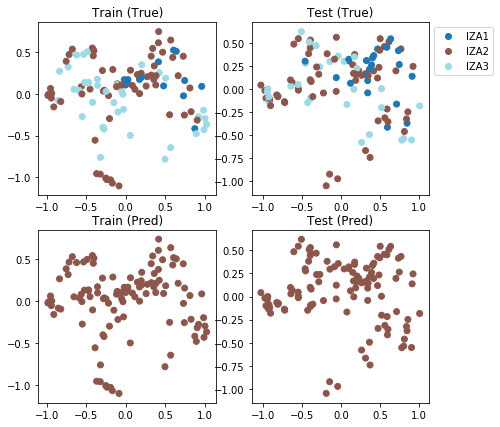

In [83]:
# Plot
fig = plt.figure(figsize=(7.0, 7.0))
axs_true_train = fig.add_subplot(2, 2, 1)
axs_true_test = fig.add_subplot(2, 2, 2)
axs_pred_train = fig.add_subplot(2, 2, 3)
axs_pred_test = fig.add_subplot(2, 2, 4)

# Scatter plots colored by canton
axs_true_train.scatter(T_train[:, 0], T_train[:, 1], c=Y_true_train, cmap='tab20', vmin=1, vmax=3)
axs_true_test.scatter(T_test[:, 0], T_test[:, 1], c=Y_true_test, cmap='tab20', vmin=1, vmax=3)
axs_pred_train.scatter(T_train[:, 0], T_train[:, 1], c=Y_pred_train, cmap='tab20', vmin=1, vmax=3)
axs_pred_test.scatter(T_test[:, 0], T_test[:, 1], c=Y_pred_test, cmap='tab20', vmin=1, vmax=3)

axs_true_train.set_title('Train (True)')
axs_true_test.set_title('Test (True)')

axs_pred_train.set_title('Train (Pred)')
axs_pred_test.set_title('Test (Pred)')

# Custom legend to make sure everything is colored correctly
handles = [Line2D([0], [0], c=plt.get_cmap('tab20')(0.0), marker='o', linewidth=0),
           Line2D([0], [0], c=plt.get_cmap('tab20')(0.50), marker='o', linewidth=0),
           Line2D([0], [0], c=plt.get_cmap('tab20')(1.0), marker='o', linewidth=0)]
labels = ['IZA1', 'IZA2', 'IZA3']
axs_true_test.legend(handles=handles, labels=labels, loc='upper left', bbox_to_anchor=(1.0, 1.0))

plt.show()

In [84]:
# Simple classification accuracy
train_accuracy = np.count_nonzero(Y_pred_train == Y_true_train) / len(Y_iza_train)
test_accuracy = np.count_nonzero(Y_pred_test == Y_true_test) / len(Y_iza_test)

print(train_accuracy)
print(test_accuracy)

0.5535714285714286
0.5309734513274337


In [85]:
# Matrix of simple classification/misclassification
train_scores = np.zeros((4, 4))
test_scores = np.zeros((4, 4))
for i in range(0, 3):
    idxs_i_train = np.nonzero(Y_true_train == i+1)[0]
    idxs_i_test = np.nonzero(Y_true_test == i+1)[0]
    for j in range(0, 3):
        train_score = np.count_nonzero(Y_pred_train[idxs_i_train] == j+1) / idxs_i_train.size
        train_scores[i, j] = train_score
        
        test_score = np.count_nonzero(Y_pred_test[idxs_i_test] == j+1) / idxs_i_test.size
        test_scores[i, j] = test_score
        
print(train_scores)
print(test_scores)

[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]]


## DEEM projected on IZA latent space

In [86]:
# Load train and test sets
train_idxs = np.loadtxt('../Processed_Data/DEEM_10k/train.idxs', dtype=int)
test_idxs = np.loadtxt('../Processed_Data/DEEM_10k/test.idxs', dtype=int)

# Total number of structures
n_structures = train_idxs.size + test_idxs.size

In [87]:
# Subselection of train and test sets
n_deem = 500

deem_idxs = np.arange(0, train_idxs.size)
np.random.shuffle(deem_idxs)
deem_idxs = train_idxs[deem_idxs[0:n_deem]]

In [88]:
cutoff = 6.0

# Load SOAPs
deem_file = f'../Processed_Data/DEEM_10k/Data/{cutoff}/soaps.hdf5'
deem_soaps = load_structures_from_hdf5(deem_file, datasets=None, concatenate=False)

In [89]:
# Build the collection of soap vectors
# as a list of numpy arrays, where each list element
# corresponds do a structure
deem = [deem_soaps[i] for i in deem_idxs]

In [90]:
K_deem_iza = build_kernel(deem, iza_train, kernel='gaussian', gamma=10.0)

100%|██████████| 500/500 [00:22<00:00, 22.20it/s]


In [91]:
K_deem_iza_centered = center_kernel(K_deem_iza, K_ref=K_train)

In [92]:
T_deem, _, _ = kpcovr.transform(K=K_deem_iza_centered)

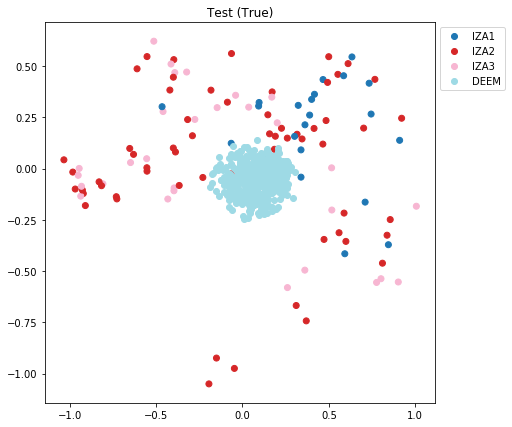

In [93]:
# Plot
fig = plt.figure(figsize=(7.0, 7.0))
axs = fig.add_subplot(1, 1, 1)

# Scatter plots colored by canton
axs.scatter(T_test[:, 0], T_test[:, 1], c=Y_true_test, cmap='tab20', vmin=1, vmax=4)
axs.scatter(T_deem[:, 0], T_deem[:, 1], c=np.asarray(plt.get_cmap('tab20')(1.0))[np.newaxis, :])

axs.set_title('Test (True)')

# Custom legend to make sure everything is colored correctly
handles = [Line2D([0], [0], c=plt.get_cmap('tab20')(0.0), marker='o', linewidth=0),
           Line2D([0], [0], c=plt.get_cmap('tab20')(0.33), marker='o', linewidth=0),
           Line2D([0], [0], c=plt.get_cmap('tab20')(0.67), marker='o', linewidth=0),
           Line2D([0], [0], c=plt.get_cmap('tab20')(1.0), marker='o', linewidth=0)]
labels = ['IZA1', 'IZA2', 'IZA3', 'DEEM']
axs.legend(handles=handles, labels=labels, loc='upper left', bbox_to_anchor=(1.0, 1.0))

plt.show()